In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

Link towards reporting gsheet document:
https://docs.google.com/spreadsheets/d/1o0O9HGCUABQWF1C6uHw65veY9Axd3pATWwdG2WSpdf8/edit?usp=sharing

In [2]:
# Parameters corresponding to gsheet file
CLASS_NBR = 6
MODE = "cached" # "direct" or "cached"
KERNEL = "linear" # "linear" or "rbf"
LR = 0.5
C = 10

In [3]:
# Local parameters
BATCH_SIZE = 64
CNN_OUTPUT_DIR = os.path.join("..", "tmp", "cnn_output", "VGG16")
TARGET_W = 224
TRAIN_STEPS = 2000
MODEL_DIR_DIRECT = None#"../tmp/estimator_svdd_naive_direct"
MODEL_DIR_CACHED = None#"../tmp/estimator_svdd_naive_cached"

# Input data

In [4]:
from data_utils import train_cnn_input_fn, test_cnn_input_fn, train_input_fn, test_input_fn

# Sanity check
train_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), test_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), train_input_fn(
    CLASS_NBR,
    TARGET_W
), test_input_fn(
    CLASS_NBR,
    TARGET_W
)

(<MapDataset shapes: (25088,), types: tf.float32>,
 <MapDataset shapes: ((25088,), <unknown>), types: (tf.float32, tf.int32)>,
 <MapDataset shapes: (224, 224, 3), types: tf.float32>,
 <MapDataset shapes: ((224, 224, 3), <unknown>), types: (tf.float32, tf.int32)>)

# Training

In [5]:
from estimator_svdd_naive import OCClassifier as SVDDClassifier

if MODE == "cached":
    input_fn_train = lambda: train_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(BATCH_SIZE).repeat()
    input_fn_test = lambda: test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(BATCH_SIZE)
    train_hooks = []
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_CACHED
elif MODE == "direct":
    from vgg_network import VGG_Network
    from estimator_svdd_naive import _LoadPreTrainedWeightsVGG
    from data_utils import run_dataset_through_network
    
    net = VGG_Network(include_FC_head=False)
    
    def get_train_dataset(net, reuse=False):
        dataset = train_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset.repeat()
    
    def get_test_dataset(net, reuse=False):
        dataset = test_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = dataset.map(lambda img, label: img)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset
    
    input_fn_train = lambda: get_train_dataset(net, reuse=False)
    input_fn_test = lambda: get_test_dataset(net, reuse=False)
    train_hooks = [_LoadPreTrainedWeightsVGG(net)]
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_DIRECT
else:
    raise Exception("MODE unknown")
    
classifier = SVDDClassifier(
    c=C,
    kernel=KERNEL,
    learning_rate=LR,
    model_dir=MODEL_DIR,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_task_type': 'worker', '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_evaluation_master': '', '_train_distribute': None, '_service': None, '_log_step_count_steps': 100, '_tf_random_seed': None, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_model_dir': '/tmp/tmp8zau5t5i', '_session_config': None, '_task_id': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd20e86de80>, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000}


In [6]:
classifier.train(
    input_fn=input_fn_train,
    steps=TRAIN_STEPS,
    hooks=train_hooks
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp8zau5t5i/model.ckpt.
INFO:tensorflow:loss = 8570081.0, step = 0
INFO:tensorflow:global_step/sec: 15.6823
INFO:tensorflow:loss = 907786.75, step = 100 (6.377 sec)
INFO:tensorflow:global_step/sec: 16.0575
INFO:tensorflow:loss = 257784.75, step = 200 (6.228 sec)
INFO:tensorflow:global_step/sec: 15.2789
INFO:tensorflow:loss = 164016.36, step = 300 (6.545 sec)
INFO:tensorflow:global_step/sec: 15.7808
INFO:tensorflow:loss = 143822.67, step = 400 (6.338 sec)
INFO:tensorflow:global_step/sec: 14.7705
INFO:tensorflow:loss = 147894.61, step = 500 (6.769 sec)
INFO:tensorflow:global_step/sec: 15.8461
INFO:tensorflow:loss = 141166.81, step = 600 (6.313 sec)
INFO:tensorflow:global_step/sec: 14.5107
INFO:tensorflow:

# Predicting

In [7]:
predictions = classifier.predict(
    input_fn=input_fn_test,
    hooks=test_hooks
)

predictions_list = list(predictions)
predicted_scores = np.asarray(list(map(lambda p: p["predicted_scores"], predictions_list))).astype(np.int32)
predicted_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list))).astype(np.int32)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8zau5t5i/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [8]:
df = pd.DataFrame(predicted_classes)
df.plot.hist()

# Validation and metrics

In [9]:
# Test set
y_test = []
input_fn = test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(1)
input_fn = input_fn.make_one_shot_iterator().get_next()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        y_test.append(data[1][0])
    except tf.errors.OutOfRangeError:
        break
y_test = np.asarray(y_test)
y_test.shape

(300,)

Normalized confusion matrix
[[0.32666667 0.67333333]
 [0.12666667 0.87333333]]


Accuracy     0.600000
Precision    0.564655
Recall       0.873333
f1-score     0.685864
dtype: float64

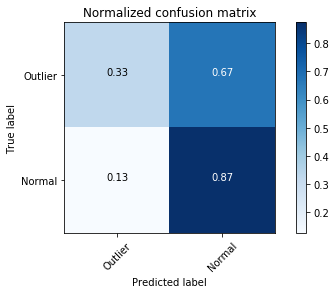

In [10]:
from validation import evaluation_summary
evaluation_summary(y_test, predicted_classes, plot_cm=True)